In [6]:
import sys
sys.path.append("/home/maciej/repos/scikit-learn")

import cv2
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from dataset_io import *
import numpy as np
from joblib import dump, load
import timeit
import random
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Gradient features - RandomForest

In [2]:
pallet_X=np.load(PROJECT_PATH+"pallet_rectangles_gradient.npy")
background_X=np.load(PROJECT_PATH+"background_rectangles_gradient.npy")

pallet_X=[np.dstack(x) for x in pallet_X]
background_X=[np.dstack(x) for x in background_X]

print(np.array(pallet_X).shape)
print(np.array(background_X).shape)

pallet_X=[x.flatten() for x in pallet_X]
background_X=[x.flatten() for x in background_X]

pallet_y=np.ones(len(pallet_X))
background_y=np.zeros(len(background_X))

X=np.vstack((pallet_X,background_X))
y=np.hstack((pallet_y,background_y))

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
sss.get_n_splits(X, y)
train_index, test_index = list(sss.split(X, y))[0]
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

(2591, 22, 120, 8)
(7240, 22, 120, 8)


In [3]:
clf = RandomForestClassifier(128, n_jobs=-1) #128 is as fast as lower sizes and as accurate as greater sizes
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

acc=accuracy_score(y_test, y_pred)
prec=precision_score(y_test, y_pred)
rec=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)

print("acc: ",acc," f1: ",f1," prec: ",prec," rec: ",rec)

acc:  0.9972881355932204  f1:  0.9948253557567917  prec:  1.0  rec:  0.9897039897039897


In [21]:
dump(clf, 'rand_forest_clf.joblib') 

['rand_forest_clf.joblib']

[[2173    0]
 [   8  769]]


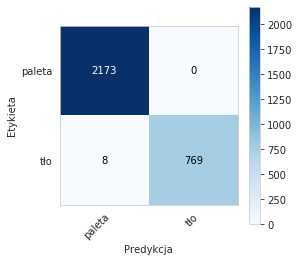

In [11]:
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etykieta',
           xlabel='Predykcja')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

visualize_confusion_matrix(y_test, y_pred, ["paleta", "tło"], title=None)

# Color features - NaiveBayes

In [5]:
pallet_pix_counts=[41_068_649, 2_327_191, 22_571_243]
pallet_pix_count_map=dict(zip(COLORS, pallet_pix_counts))

In [6]:
def readnsplit(color):
    #-------------y-------------------------
    pallet_pix_count=pallet_pix_count_map[color]
    background_pix_count=pallet_pix_count*2
    
    pallet_y=np.ones(pallet_pix_count, dtype=bool)
    background_y=np.zeros(background_pix_count, dtype=bool)

    y=np.hstack((pallet_y,background_y))

    pallet_y=None
    background_y=None

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
    sss.get_n_splits(y, y)
    train_index, test_index = list(sss.split(y, y))[0]
    sss=None

    y_train, y_test = y[train_index], y[test_index]
    y=None

    #-------------X-------------------------
    background_X=np.load(PROJECT_PATH+"backgrounds_color.npy", allow_pickle=True)
    background_X=np.array([np.hstack(x) for x in background_X])
    background_X=np.concatenate(background_X, 0)
    indices=range(len(background_X))
    indices=random.sample(indices, background_pix_count)
    background_X=background_X[indices]
    
    pallet_X=np.load(PROJECT_PATH+"pallets_color_{}.npy".format(color), allow_pickle=True)
    pallet_X=np.array([np.hstack(x) for x in pallet_X])
    pallet_X=np.concatenate(pallet_X, 0)

    X=np.vstack((pallet_X,background_X))

    pallet_X=None
    background_X=None

    X_train, X_test = X[train_index], X[test_index]
    X=None
    return X_train, X_test, y_train, y_test

In [7]:
def classify(X_train, X_test, y_train, y_test):  
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    X_train=None
    y_train=None
    y_pred=clf.predict(X_test)
    X_test=None

    acc=accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    cm=confusion_matrix(y_test, y_pred, labels=[True, False])

    print("acc: ",acc," f1: ",f1)
    print(cm)
    return clf

In [8]:
for color in COLORS:
    print(color)
    X_train, X_test, y_train, y_test=readnsplit(color)
    clf=classify(X_train, X_test, y_train, y_test)
    dump(clf, 'naive_bayes_clf_{}.joblib'.format(color)) 

blue
acc:  0.8239324751226165  f1:  0.7702884668874723
[[10911207  1409388]
 [ 5098382 19542808]]
dark
acc:  0.9190273252638373  f1:  0.8841500110320312
[[ 647162   50995]
 [ 118600 1277715]]
wooden
acc:  0.8794363664011223  f1:  0.8290738061831864
[[ 5939760   831613]
 [ 1617531 11925215]]


## Check pallet pixels count per color

In [9]:
for color in COLORS:
    pallet_X=np.load(PROJECT_PATH+"pallets_color_{}.npy".format(color), allow_pickle=True)
    pallet_X=np.array([np.hstack(x) for x in pallet_X])
    pallet_X=np.concatenate(pallet_X, 0)
    print(pallet_X.shape)

(41068649, 6)
(2327191, 6)
(22571243, 6)
